In [ ]:
#| default_exp preprocess

In [ ]:
#| hide
from nbdev.showdoc import *

# preprocess
> This module will contain the functions used to preprocess the data to be used in the training process and it will contain the preprocessing done to successfully batch data

In [ ]:
#| export
from pathlib import Path
import librosa
from numpy import array
import torch
import pyworld as pw
import numpy as np
from torch.nn.utils.rnn import pad_sequence
import noisereduce as nr
from fastcore.foundation import L
from torch import tensor

In [ ]:
#| hide
torch.set_printoptions(2, linewidth=140, sci_mode=False)

In [ ]:
#| hide
from fastspeech.loading import *
from functools import partial
from fastspeech.visualize import show_mels, show_mel, plot
from fastspeech.loading import melspectrogram

In [ ]:
#| hide
path = Path("../sample_data/")
sr = 22050
hl = 256
cut = 10

file_paths = get_audio_files(path).filter(lambda x: "demonstration" not in str(x))
tgt_paths = L(file_paths).map(partial(replace_extension, extension='.TextGrid'))
vocab_path = Path("../sample_data/cmudict-0.7b.symbols.txt")

wavs = list(map(partial(load_audio, sr=22050), file_paths[:cut]))
phones, durations = zip(*map(partial(get_phones_and_durations, sr=sr, hl=hl), 
                             tgt_paths[:cut]))

## utils

In [ ]:
#| export
def map_tensors(inp: list[list]):
    return list(map(tensor, inp))

In [ ]:
durations = list(map(tensor, durations))
duration = durations[0]
duration

tensor([ 6.03,  6.03,  3.45,  6.03,  8.61,  4.31,  6.03,  2.58,  5.17, 10.34,  4.31,  9.47,  4.31,  7.75,  5.17,  6.03,  8.61,  5.17, 10.34,
        13.78,  4.31,  8.61, 11.20])

In [ ]:
#| export
def argmax_all(tens):
    max_val = 0
    max_idxs = []
    for i in range(len(tens)):
        val = tens[i].item()
        if val > max_val:
            max_val = val
            max_idxs = [i]
        elif val == max_val:
            max_idxs.append(i)
    return max_idxs

In [ ]:
argmax_all(duration)

[19]

In [ ]:
#| export
def pad_max_seq(seq: list[tensor], pad_val=0, pad_len=1):
    seq_pad = L(seq[:])
    max_idxs = argmax_all(tensor(seq_pad.map(len)))
    for idx in max_idxs:
        seq_pad[idx] = torch.cat((seq_pad[idx], torch.tensor([pad_val]*pad_len)))
    return seq_pad

In [ ]:
pad_max_seq(durations)[0][-1]

tensor(11.20)

## phones

In [ ]:
#| export
class Vocab:
    '''This is a vocab object to used to load in a vocabulary, vectorize phonemes, and decode embeddings'''
    def __init__(self, 
                 vocab_path: str, # The path to vocabulary file containing all the words in the vocabulary
                 specials: list =[]): # The special tokens not in the vocabulary file
        pad_token = "<pad>"
        self.vocab = self._load_vocab(vocab_path) + [pad_token] + specials
        self.tok2idx = {tok: i for i, tok in enumerate(self.vocab)}
        self.pad_num = self.tok2idx[pad_token]
    
    def __getitem__(self, val): # The token string or the vectorized integer
        val_type = type(val)
        if val_type == int and val < len(self.vocab): 
            return self.vocab[val]
        elif val_type == str:
            return self.tok2idx[val]
        else:
            raise Exception(f"Used the wrong type: {val_type}")
        
    def __len__(self):
        return len(self.vocab)
        
    def _load_vocab(self, vocab_path: str): # The path to the phoneme vocab list
        lines = Path(vocab_path).open().readlines()
        return list(map(lambda x: x.strip(), lines))

In [ ]:
vocab = Vocab(vocab_path, ['spn'])
vocab[10], vocab[vocab[10]], len(vocab)

('AH1', 10, 86)

In [ ]:
#| export
def phones_list_to_num(phones: list[list[int]], vocab: Vocab):
    nums = L(phones).map(lambda x: L(x).map(vocab.__getitem__))
    return nums

In [ ]:
nums = phones_list_to_num(phones, vocab)
nums

(#2) [[44, 55, 24, 49, 44, 56, 52, 9, 54, 65, 6, 66, 9, 69, 44, 79, 53, 50, 54, 2, 26, 33, 55],[65, 66, 45, 55, 69, 44, 56, 44, 55, 27, 9, 59, 55, 53, 48, 67, 30, 55, 67, 80, 45, 27, 80, 45, 25, 80, 49, 2, 66, 6, 69, 65, 66, 30, 82, 9, 55, 69, 52, 9, 55, 67, 34, 55, 26, 26, 45, 40, 33, 82, 40, 66, 10, 54, 54, 59, 67, 69, 45, 40, 55, 2, 69, 40, 66, 10, 54, 14, 53, 27, 9, 2, 66, 69, 67, 9, 55, 26, 52, 66, 6, 40, 69, 67, 66, 31, 65, 66, 9, 82, 30, 55, 69, 9, 26, 44, 55, 27, 9, 31, 52, 67, 9, 24, 45, 68, 9, 55]]

In [ ]:
#| export 
def pad_phones(phones: list[tensor], pad_num: int):
    return pad_sequence(phones, batch_first=True, padding_value=pad_num)

In [ ]:
pad_phones(map_tensors(nums), vocab.pad_num).shape

torch.Size([2, 108])

## audio

In [ ]:
#| hide
mels = list(map(melspectrogram, wavs))
mel = mels[0]
wav = wavs[0]

In [ ]:
#| export
def trim_audio(inp: array, # Input audio array
               top_db: int, # The threshold (in decibels) below reference to consider as silence
               n_fft: int, # The number of samples per analysis frame
               hl: int): # The number of samples between analysis frames
    audio, _  = librosa.effects.trim(y=inp, top_db=top_db, frame_length=n_fft, hop_length=hl)
    return audio

In [ ]:
trimmed = trim_audio(wav, top_db=30, n_fft=1024, hl=256)
len(wav) - len(trimmed)

2205

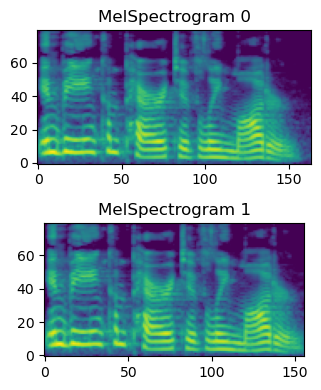

In [ ]:
trimmed_mel = melspectrogram(trimmed)
show_mels([mel, trimmed_mel]);

In [ ]:
#| hide
from IPython.display import Audio, display

In [ ]:
display(Audio(wav, rate=sr))
display(Audio(trimmed, rate=sr))

In [ ]:
#| export
def reduce_noise(wav, sr, *args, **kwargs):
    return nr.reduce_noise(wav, sr=sr, *args, **kwargs)

In [ ]:
reduced_noise = reduce_noise(wav, sr)
display(Audio(reduced_noise, rate=sr))

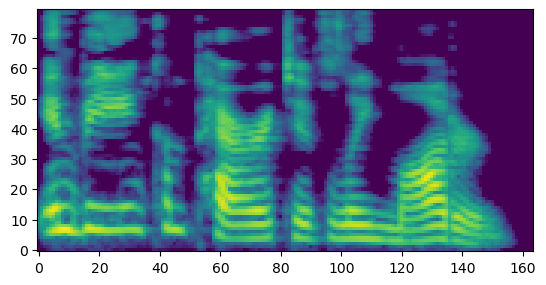

In [ ]:
show_mel(melspectrogram(reduced_noise))

In [ ]:
#| export 
def pad_mels(mels: list[tensor], norm_val=0):
    return pad_sequence(L(mels).map(lambda x: x.T), batch_first=True, 
                        padding_value=norm_val).transpose(1, 2)

In [ ]:
padded_mels = pad_mels(map_tensors(mels))
padded_mels.shape

torch.Size([2, 80, 832])

In [ ]:
#| export
def extract_pitch(wav, sr=22050, hop_length=256):
    f0, t = pw.dio(wav.astype(np.float64), fs=sr, 
               frame_period=hop_length/sr * 1000)
    pitch = pw.stonemask(wav.astype(np.float64), f0, t, fs=sr)
    return pitch.astype(np.float32)

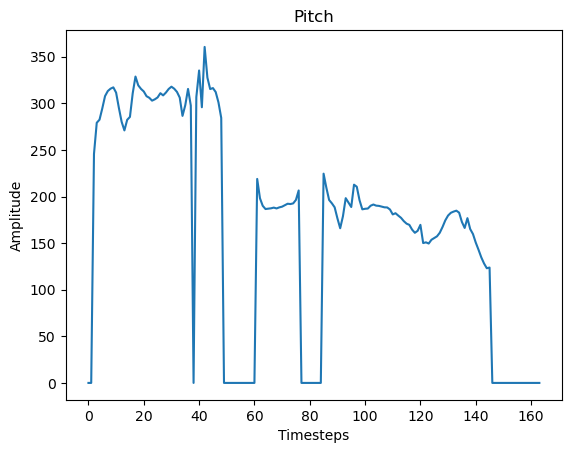

In [ ]:
pitch = extract_pitch(wav)
plot(pitch, "Pitch", "Timesteps", "Amplitude")

In [ ]:
#| export
def extract_energy(wav, n_fft=1024, hop_length=256):
    stft = librosa.stft(y=wav, n_fft=n_fft, hop_length=hop_length)
    amplitude = np.abs(stft)
    energy = np.linalg.norm(amplitude, axis=0)
    return energy

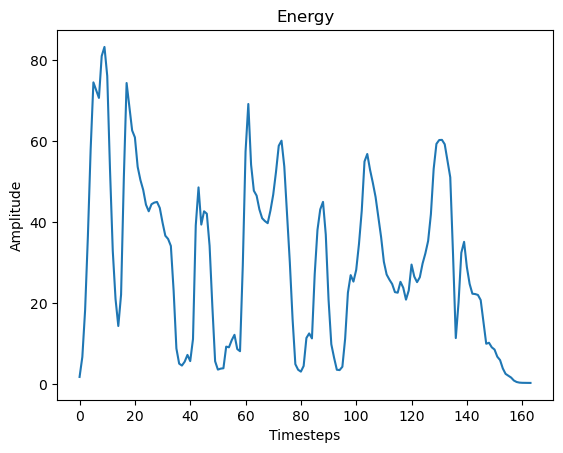

In [ ]:
energy = extract_energy(wav)
plot(energy, "Energy", "Timesteps", "Amplitude")

## durations

In [ ]:
#| hide
mel_len = mel.shape[-1]

In [ ]:
#| export
def round_and_align_durations(duration: tensor, mel_len: int):
    '''Rounds duration such that durations add up to the mel length and if 
    they don\'t add up it adds to each phoneme based on difference between 
    rounded and duration'''
    rounded_duration = duration.round()
    total_duration = rounded_duration.sum().int().item()
    
    if total_duration != mel_len:
        unit = -1 if total_duration > mel_len else 1
        
        descending = True if unit == 1 else False
        sorted_idxs = torch.argsort((rounded_duration-duration), descending=descending)
        n = len(sorted_idxs)
        
        difference = int(abs(total_duration - mel_len))
        for i in range(difference):
            idx = sorted_idxs[i % n]
            rounded_duration[idx] += unit
            
    return rounded_duration

In [ ]:
rounded = round_and_align_durations(duration, mel_len)
rounded

tensor([ 6.,  6.,  3.,  7., 10.,  4.,  7.,  4.,  5., 10.,  4.,  9.,  4.,  9.,  5.,  6., 10.,  5., 10., 15.,  4., 10., 11.])

In [ ]:
#| hide
rounded_durations = [round_and_align_durations(d, mels[i].shape[-1]) 
                     for i, d in enumerate(durations)]

In [ ]:
#| export 
def pad_duration(duration: list[tensor], mel_len: int):
    padded_duration = pad_sequence(duration, batch_first=True)
    padded_duration_amount = [mel_len - dur.sum().item() for dur in duration]
    padded_duration[:, -1] = tensor(padded_duration_amount)
    return padded_duration

In [ ]:
padded_durations = pad_duration(pad_max_seq(rounded_durations), padded_mels.shape[-1])
padded_durations.shape

torch.Size([2, 109])

## regularization

In [ ]:
#| export
def flatten_and_concat(arrays: list[array]):
    concatenated_arrays = np.concatenate([a.flatten() for a in arrays])
    return concatenated_arrays

In [ ]:
flattened = flatten_and_concat(mels)
flattened.shape

(79680,)

In [ ]:
#| export
class ZScoreNormalization:
    def __init__(self, mean: float, std: float, *args, **kwargs):
        '''Creates a normalization object that allows for normalization and 
        denormalization'''
        self.mean, self.std = mean, std
        
    def normalize(self, inp: tensor):
        return (inp - self.mean) / self.std
    
    def denormalize(self, inp: tensor):
        return inp * self.std + self.mean

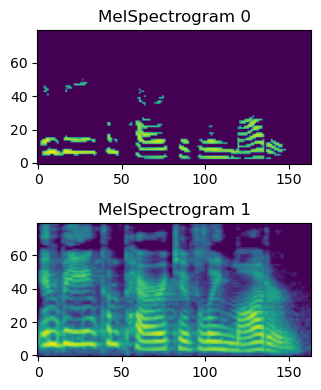

In [ ]:
mean, std = flattened.mean(), flattened.std()
norm = ZScoreNormalization(mean, std)

normalized_mel = norm.normalize(mel)
denormalized_mel = norm.denormalize(normalized_mel)

show_mels([normalized_mel, denormalized_mel])

In [ ]:
#| export
class MinMaxNormalization:
    def __init__(self, max_val: float, min_val: float, *args, **kwargs):
        '''Creates a normalization object that allows for normalization and 
        denormalization'''
        self.max_val, self.min_val = max_val, min_val
    
    def normalize(self, inp):
        return (inp - self.min_val) / (self.max_val - self.min_val)
    
    def denormalize(self, inp):
        return inp * (self.max_val - self.min_val) + self.min_val

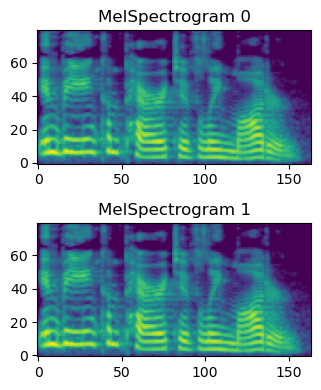

In [ ]:
max_val, min_val = flattened.max(), flattened.min()
norm = MinMaxNormalization(max_val, min_val)

normalized_mel = norm.normalize(mel)
denormalized_mel = norm.denormalize(normalized_mel)

show_mels([normalized_mel, denormalized_mel])

In [ ]:
#| export
class NoNorm:
    def __init__(self, *args, **kwargs):
        pass
    def normalize(self, inp):
        return inp
    def denormalize(self, inp):
        return inp

## quantization

In [ ]:
#| export
def torch_digitize(tensor, bins, device=None):
    indices = torch.zeros_like(tensor, device=device)
    for idx, bin_val in enumerate(bins):
        indices += (tensor >= bin_val).long()
    return indices

In [ ]:
#| export
def linear_quantization(vals, n_bins, min_v=None, max_v=None, device=None):
    if min_v is None: min_v = vals.min().detach().item()
    if max_v is None: max_v = vals.max().detach().item()

    bins = torch.linspace(min_v, max_v, n_bins - 1, device=device)
    
    quantized_vals = torch_digitize(vals, bins, device=device) - 1
    return quantized_vals.to(torch.int)

In [ ]:
linear_quantization(tensor(pitch), 256)

tensor([  0,   0, 173, 196, 198, 207, 216, 220, 222, 223, 219, 207, 197, 190, 198, 201, 218, 231, 224, 222, 220, 216, 215, 213, 214, 215,
        219, 217, 219, 222, 223, 222, 219, 215, 201, 209, 222, 209,   0, 216, 236, 208, 253, 230, 222, 222, 219, 212, 200,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0, 154, 139, 133, 131, 131, 131, 132, 131, 132, 133, 134, 135, 135, 135, 138, 145,   0,
          0,   0,   0,   0,   0,   0,   0, 158, 147, 138, 135, 132, 124, 116, 126, 139, 136, 132, 149, 148, 138, 131, 131, 131, 133, 134,
        134, 133, 133, 132, 132, 131, 127, 128, 126, 124, 122, 120, 119, 115, 113, 114, 119, 105, 106, 105, 108, 109, 110, 113, 117, 122,
        126, 128, 129, 130, 128, 121, 117, 124, 116, 112, 106, 100,  94,  90,  86,  87,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0], dtype=torch.int32)

In [ ]:
#| export
def logarithmic_quantization(vals, n_bins, min_v=None, max_v=None, device=None):
    if min_v is None: min_v = vals.min()
    if max_v is None: max_v = vals.max()
        
    min_v = tensor(max(min_v, 1e-20))
    max_v = tensor(max(max_v, min_v * 1.0001))
    
    min_v = min_v * 0.99993
    import pdb; pdb.set_trace
        
    bins = torch.logspace(torch.log10(min_v), torch.log10(max_v), n_bins, device=device)
    
    quantized_vals = torch_digitize(vals, bins, device=device)
    return quantized_vals.to(torch.int)

In [ ]:
logarithmic_quantization(tensor(pitch), 256)

/var/folders/g1/zlrqg2nj6xz42rpkl65b1h_40000gn/T/ipykernel_98726/1756736492.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  max_v = tensor(max(max_v, min_v * 1.0001))


tensor([  0,   0, 254, 254, 254, 255, 255, 255, 255, 255, 255, 255, 254, 254, 254, 254, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255, 255, 255, 255, 255, 255, 255, 254, 255, 255, 255,   0, 255, 255, 255, 256, 255, 255, 255, 255, 255, 254,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0, 253, 253, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 253, 253,   0,
          0,   0,   0,   0,   0,   0,   0, 253, 253, 253, 252, 252, 252, 252, 252, 253, 252, 252, 253, 253, 253, 252, 252, 252, 252, 252,
        252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 251, 251, 251, 251, 251, 251, 252, 252, 252,
        252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 251, 251, 251, 250, 250, 250,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0], dtype=torch.int32)

## transform

In [ ]:
#| export
def transform_inp(inp, transform_list: list):
    x = inp
    for transform in transform_list:
        x = transform(inp)
    return x

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()